# Preparation

ライブラリのインポート

In [1]:
# その他
import io, os, sys, types
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime as dt
import pandas_datareader.data as web
import networkx as nx


# 基礎データ分析
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

# 応用データ分析


自作ライブラリのインポート

In [2]:
# 自作ライブラリ
sys.path.append('../database/')
from Functions import (
  plot_stock_prices,
  plot_histogram,
  display_dataframes_with_buttons,
  display_images_with_buttons,
  perform_adf_test_on_dataframe,
  remove_trend_log,
  display_order_selection,
  calculate_garch_volatility,
  )

表示設定

In [3]:
# 行と列の表示数を設定
pd.set_option('display.max_rows', 100)  # 行の最大表示数を無制限に
pd.set_option('display.max_columns', None)  # 列の最大表示数を無制限に
pd.set_option('display.width', None)  # 表示幅を広げる
pd.set_option('display.max_colwidth', None)  # 列の最大幅を無制限に

# グラフのスタイルの設定
sns.reset_defaults() # スタイルをデフォルトにリセット
sns.set_style('darkgrid') # スタイルを設定
sns.despine() # グラフの枠を非表示
sns.set_palette("winter",
                n_colors=8, # 使用する色の設定
                desat=0.5 # 色の彩度
                )

# グラフの言語設定
import japanize_matplotlib
sns.set(font='IPAexGothic')

# グリッドのスタイルを設定
mpl.rcParams['axes.grid'] = True # グリッドの有無
mpl.rcParams['axes.grid.axis'] = 'y'  # y軸に沿ったグリッドのみ表示
mpl.rcParams['grid.linestyle'] = '--' # グリッド線の種類
mpl.rcParams['grid.color'] = 'darkgray' # グリッドの色
mpl.rcParams['grid.linewidth'] = 1 # グリッドの太さ

mpl.rcParams['ytick.major.size'] = 0  # y軸の目盛りを非表示にする
mpl.rcParams['ytick.color'] = 'black'  # y軸ラベルの色
mpl.rcParams['xtick.major.size'] = 1  # x軸の目盛りを非表示にする
mpl.rcParams['xtick.color'] = 'black'  # x軸ラベルの色

<Figure size 640x480 with 0 Axes>

データのインポート/作成

In [4]:
# データのインポート
df_base_stock_da = pd.read_csv('../database/data_files/stock_da.csv')
df_base_stock_we = pd.read_csv('../database/data_files/stock_we.csv')
df_base_stock_mo = pd.read_csv('../database/data_files/stock_mo.csv')
df_base_topix_da = pd.read_csv('../database/data_files/topix100_1d_data.csv')
df_base_topix_we = pd.read_csv('../database/data_files/topix100_1wk_data.csv')
df_base_topix_mo = pd.read_csv('../database/data_files/topix100_1mo_data.csv')

# データの整形
df_base_topix_da = df_base_topix_da.set_index('Date')
df_base_topix_we = df_base_topix_we.set_index('Date')
df_base_topix_mo = df_base_topix_mo.set_index('Date')

df_base_stock_da = df_base_stock_da.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
df_base_stock_we = df_base_stock_we.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
df_base_stock_mo = df_base_stock_mo.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')

# 統合データ
df_base_da = pd.read_excel('../database/data_files/WEEK05_daily.xlsx')
df_base_da = df_base_da.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')

データの確認

In [5]:
display_dataframes_with_buttons({
  # トピックスの株価データ
  'トピックス(日次)': df_base_topix_da,
  'トピックス(週次)': df_base_topix_we,
  'トピックス(月次)': df_base_topix_mo,
  # 株価データ
  '株価データ(日次)': df_base_stock_da,
  '株価データ(週次)': df_base_stock_we,
  '株価データ(月次)': df_base_stock_mo,
  # トピックスの株価データ
  'トピックス(日次)統計データ': df_base_topix_da.describe(),
  'トピックス(週次)統計データ': df_base_topix_we,
  'トピックス(月次)統計データ': df_base_topix_mo.describe(),
  # 株価データ
  '株価データ(日次)統計データ': df_base_stock_da.describe(),
  '株価データ(週次)統計データ': df_base_stock_we.describe(),
  '株価データ(月次)統計データ': df_base_stock_mo.describe(),
  })

## 経済データの取得

In [6]:
# 定数の設定
start = dt.date(2013, 10, 1)
end = dt.date(2023, 11, 1)

経済データ(日次)の取得

In [7]:
# ドル円為替レート(Japanese Yen to U.S. Dollar Spot Exchange Rate)
df_economic_DollarYen = web.DataReader('DEXJPUS', 'fred', start, end)
# ーーーー＞輸入コストに関係？？
# 日系株価平均(Nikkei Stock Average, Nikkei 225 )
df_economic_NikkeiAv = web.DataReader('NIKKEI225', 'fred', start, end)
# ーーーー＞

経済データ(週次)の取得

In [8]:
# レギュラーガソリン価格
df_economic_Regular_GAS = web.DataReader('GASREGCOVW', 'fred', start, end)

経済データ月次の取得

In [9]:
# 日銀総資産(Bank of Japan: Total Assets for Japan)
df_economic_BOJ_Assets = web.DataReader('JPNASSETS', 'fred', start, end)
# ーーーー＞買いオペがわかる？
# 日本長期金利(Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for Japan)
df_economic_JP_longInterest = web.DataReader('IRLTLT01JPM156N', 'fred', start, end)
# ーーーー＞



# 鉄の価格
df_economic_STEEL_PRICE = web.DataReader('WPU10170502', 'fred', start, end)
# 車の転売
df_economic_Retail_CAR = web.DataReader('MRTSSM44112USN', 'fred', start, end)
# 自動車関係の従業員数
df_economic_Car_Employee = web.DataReader('CES3133600101', 'fred', start, end)
# アルミニウムの価格
df_economic_Aluminum_Price = web.DataReader('PALUMUSDM', 'fred', start, end)
# 車の総売上
df_economic_SALES = web.DataReader('TOTALSA', 'fred', start, end)
# 関税(3ヶ月に1回)
df_economic_Tariff = web.DataReader('B235RC1Q027SBEA', 'fred', start, end)
# GDP(3ヶ月に1回)
df_economic_GDP = web.DataReader('GDP', 'fred', start, end)

In [10]:
df_economic_JP_longInterest

,IRLTLT01JPM156N
DATE,
2013-10-01,0.590
2013-11-01,0.605
2013-12-01,0.688
2014-01-01,0.614
2014-02-01,0.586
...,...
2023-06-01,0.395
2023-07-01,0.595
2023-08-01,0.640


その他データ取得


In [11]:
API_KEY = '2IPXB7ZSYNPRUB6Y'

# 定数の設定
start = dt.datetime(2013, 11, 1)
end = dt.datetime(2023, 11, 1)

# 複数の銘柄のリスト
tickers = ['BZ', ]  # 例として4つの銘柄を取得します。必要に応じてリストを変更してください。

# データフレームの初期化
df_test = pd.DataFrame()

# 各銘柄のデータ取得
for ticker in tickers:
    df_stock = web.DataReader(
        ticker,
        'av-daily',
        start,
        end,
        api_key=API_KEY
    )
    
    # closeの価格だけを取得し、カラム名を銘柄名に変更
    df_stock = df_stock[['close']].rename(columns={'close': ticker})
    
    # 合成データフレームへの追加
    if df_test.empty:
        df_test = df_stock
    else:
        df_test = df_test.join(df_stock)

df_test.tail(30)

,BZ
2023-09-21,14.55
2023-09-22,15.18
2023-09-25,15.34
2023-09-26,14.67
2023-09-27,14.70
2023-09-28,15.04
2023-09-29,15.17
2023-10-02,15.49
2023-10-03,15.37
2023-10-04,15.09


データ確認

In [12]:
df_base_da

,8031.T,8001.T,8058.T,7011.T,5711.T,4188.T,CL=F,BZ=F,NG=F,HO=F,GC=F,SI=F,HG=F,ZC=F,ZS=F,KC=F,^VIX,JPY=X,NIY=F,TOPIX100.T,^N225
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-01,751.439819,441.594788,1220.801392,2094.356201,1943.296387,274.705902,82.949997,84.620003,3.832,2.2777,1350.199951,24.548000,3.7785,577.25,1225.25,197.699997,21.830000,80.405998,9120.000000,NaN,9154.719727
2010-11-02,746.042480,450.363922,1236.533569,2072.075684,1928.055054,286.068451,83.900002,85.410004,3.870,2.2936,1356.400024,24.832001,3.8335,575.75,1223.75,199.399994,21.570000,80.558998,9210.000000,NaN,9159.980469
2010-11-04,757.437012,461.638702,1274.290283,2101.782715,1950.917114,292.083923,86.489998,88.000000,3.856,2.3731,1382.699951,26.039000,3.9065,590.00,1264.75,205.800003,18.520000,81.050003,9470.000000,NaN,9358.780273
2010-11-05,791.021240,484.188232,1312.676270,2183.477051,2004.262451,302.109711,86.849998,88.110001,3.937,2.3848,1397.300049,26.743999,3.9440,587.75,1273.50,205.149994,18.260000,80.776001,9700.000000,NaN,9625.990234
2010-11-08,810.811401,487.320068,1318.339722,2176.051270,2072.849609,308.125183,87.059998,88.459999,4.088,2.3977,1402.800049,27.427999,3.9525,585.25,1264.50,208.100006,18.290001,81.139999,9710.000000,NaN,9732.919922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02,5553.000000,5599.000000,6891.000000,7955.000000,2447.500000,929.599976,82.459999,86.849998,3.472,3.0255,1985.599976,22.750999,3.6670,470.00,1304.00,165.350006,15.660000,150.574997,32290.000000,1555.219971,31949.890625
2023-11-06,5754.000000,5692.000000,6998.000000,8525.000000,2471.500000,968.400024,80.820000,85.180000,3.264,2.9524,1981.599976,23.149000,3.7095,477.25,1340.50,173.699997,14.890000,149.449005,32610.000000,1582.229980,32708.480469
2023-11-07,5672.000000,5799.000000,6967.000000,8318.000000,2458.000000,964.099976,77.370003,81.610001,3.140,2.8384,1966.800049,22.507999,3.6700,468.50,1348.75,170.750000,14.810000,149.988998,32495.000000,1565.910034,32271.820312


In [13]:
tickers_dict = {
  # 株価
  '三井物産': '8031.T',
  '伊藤忠': '8001.T',
  '三菱商事': '8058.T',
  '三菱重工業': '7011.T',
  '三菱マテリアル': '5711.T',
  '三菱化学': '4188.T',
  # エネルギー
  'WTI原油先物': 'CL=F',
  'ブレント原油先物': 'BZ=F',
  '天然ガス先物': 'NG=F',
  '灯油先物': 'HO=F',
  # 金属
  '金先物': 'GC=F',
  '銀先物': 'SI=F',
  '銅先物': 'HG=F',
  # 食品
  'コーン先物': 'ZC=F',
  '大豆先物': 'ZS=F',
  'コーヒー先物': 'KC=F',
  # 金融データ
  'VIX恐怖指数': '^VIX',
  'ドル円為替': 'JPY=X',
  '日経平均': 'NIY=F',
  'TOPIX100': 'TOPIX100.T'
}


In [14]:
tickers_dict

{'三井物産': '8031.T',
 '伊藤忠': '8001.T',
 '三菱商事': '8058.T',
 '三菱重工業': '7011.T',
 '三菱マテリアル': '5711.T',
 '三菱化学': '4188.T',
 'WTI原油先物': 'CL=F',
 'ブレント原油先物': 'BZ=F',
 '天然ガス先物': 'NG=F',
 '灯油先物': 'HO=F',
 '金先物': 'GC=F',
 '銀先物': 'SI=F',
 '銅先物': 'HG=F',
 'コーン先物': 'ZC=F',
 '大豆先物': 'ZS=F',
 'コーヒー先物': 'KC=F',
 'VIX恐怖指数': '^VIX',
 'ドル円為替': 'JPY=X',
 '日経平均': 'NIY=F',
 'TOPIX100': 'TOPIX100.T'}

# データ分析

データの線グラフ表示

In [15]:
tickers_dict = {
    '三井物産': {'ティッカーシンボル': '8031.T', '英語名': 'Mitsui & Co.'},
    '伊藤忠': {'ティッカーシンボル': '8001.T', '英語名': 'Itochu Corporation'},
    '三菱商事': {'ティッカーシンボル': '8058.T', '英語名': 'Mitsubishi Corporation'},
    '三菱重工業': {'ティッカーシンボル': '7011.T', '英語名': 'Mitsubishi Heavy Industries'},
    '三菱マテリアル': {'ティッカーシンボル': '5711.T', '英語名': 'Mitsubishi Materials'},
    '三菱化学': {'ティッカーシンボル': '4188.T', '英語名': 'Mitsubishi Chemical'},
    'WTI原油先物': {'ティッカーシンボル': 'CL=F', '英語名': 'WTI Crude Oil Futures'},
    'ブレント原油先物': {'ティッカーシンボル': 'BZ=F', '英語名': 'Brent Crude Oil Futures'},
    '天然ガス先物': {'ティッカーシンボル': 'NG=F', '英語名': 'Natural Gas Futures'},
    '灯油先物': {'ティッカーシンボル': 'HO=F', '英語名': 'Heating Oil Futures'},
    '金先物': {'ティッカーシンボル': 'GC=F', '英語名': 'Gold Futures'},
    '銀先物': {'ティッカーシンボル': 'SI=F', '英語名': 'Silver Futures'},
    '銅先物': {'ティッカーシンボル': 'HG=F', '英語名': 'Copper Futures'},
    'コーン先物': {'ティッカーシンボル': 'ZC=F', '英語名': 'Corn Futures'},
    '大豆先物': {'ティッカーシンボル': 'ZS=F', '英語名': 'Soybean Futures'},
    'コーヒー先物': {'ティッカーシンボル': 'KC=F', '英語名': 'Coffee Futures'},
    'VIX恐怖指数': {'ティッカーシンボル': '^VIX', '英語名': 'VIX Index'},
    'ドル円為替': {'ティッカーシンボル': 'JPY=X', '英語名': 'USD/JPY Exchange Rate'},
    '日経平均': {'ティッカーシンボル': 'NIY=F', '英語名': 'Nikkei 225 Futures'},
    'TOPIX100': {'ティッカーシンボル': 'TOPIX100.T', '英語名': 'TOPIX100'}
}

# データフレームへの変換
import pandas as pd
tickers_df = pd.DataFrame(tickers_dict).T
tickers_df.columns = ['Ticker-Symbol', '英語名']
tickers_df


,Ticker-Symbol,英語名
三井物産,8031.T,Mitsui & Co.
伊藤忠,8001.T,Itochu Corporation
三菱商事,8058.T,Mitsubishi Corporation
三菱重工業,7011.T,Mitsubishi Heavy Industries
三菱マテリアル,5711.T,Mitsubishi Materials
三菱化学,4188.T,Mitsubishi Chemical
WTI原油先物,CL=F,WTI Crude Oil Futures
ブレント原油先物,BZ=F,Brent Crude Oil Futures
天然ガス先物,NG=F,Natural Gas Futures
灯油先物,HO=F,Heating Oil Futures


In [16]:
df_base_da.head()

,8031.T,8001.T,8058.T,7011.T,5711.T,4188.T,CL=F,BZ=F,NG=F,HO=F,GC=F,SI=F,HG=F,ZC=F,ZS=F,KC=F,^VIX,JPY=X,NIY=F,TOPIX100.T,^N225
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-01,751.439819,441.594788,1220.801392,2094.356201,1943.296387,274.705902,82.949997,84.620003,3.832,2.2777,1350.199951,24.548000,3.7785,577.25,1225.25,197.699997,21.830000,80.405998,9120.0,NaN,9154.719727
2010-11-02,746.042480,450.363922,1236.533569,2072.075684,1928.055054,286.068451,83.900002,85.410004,3.870,2.2936,1356.400024,24.832001,3.8335,575.75,1223.75,199.399994,21.570000,80.558998,9210.0,NaN,9159.980469
2010-11-04,757.437012,461.638702,1274.290283,2101.782715,1950.917114,292.083923,86.489998,88.000000,3.856,2.3731,1382.699951,26.039000,3.9065,590.00,1264.75,205.800003,18.520000,81.050003,9470.0,NaN,9358.780273
2010-11-05,791.021240,484.188232,1312.676270,2183.477051,2004.262451,302.109711,86.849998,88.110001,3.937,2.3848,1397.300049,26.743999,3.9440,587.75,1273.50,205.149994,18.260000,80.776001,9700.0,NaN,9625.990234
2010-11-08,810.811401,487.320068,1318.339722,2176.051270,2072.849609,308.125183,87.059998,88.459999,4.088,2.3977,1402.800049,27.427999,3.9525,585.25,1264.50,208.100006,18.290001,81.139999,9710.0,NaN,9732.919922


In [17]:
# フィルタリングする開始日を設定
start_date = '2023-01-01'

# 日付でフィルタリング
df_base_da_2023 = df_base_da[df_base_da.index >= start_date]

# 結果の表示（任意）
df_base_da_2023

,8031.T,8001.T,8058.T,7011.T,5711.T,4188.T,CL=F,BZ=F,NG=F,HO=F,GC=F,SI=F,HG=F,ZC=F,ZS=F,KC=F,^VIX,JPY=X,NIY=F,TOPIX100.T,^N225
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04,3622.394287,3898.648682,4065.928223,4920.159668,1980.198975,646.878235,72.839996,77.839996,4.172,2.9719,1852.800049,23.792000,3.7395,653.75,1478.25,161.300003,22.010000,131.248001,25855.000000,1237.050049,25716.859375
2023-01-05,3611.751709,3867.653320,4089.084717,4833.292969,1963.705322,655.368286,73.669998,78.690002,3.720,2.9723,1834.800049,23.257999,3.8180,652.75,1466.75,160.550003,22.459999,132.246002,25715.000000,1238.339966,25820.800781
2023-01-06,3591.433838,3841.500977,4052.419922,4906.494629,1979.228760,655.657654,73.769997,78.570000,3.710,3.0045,1864.199951,23.822001,3.9085,654.00,1501.50,158.300003,21.129999,133.307007,26200.000000,1244.609985,25973.849609
2023-01-10,3620.459229,3892.837158,4077.506348,4870.381836,2021.918091,662.796997,75.120003,80.099998,3.639,3.1357,1871.599976,23.507000,4.0670,655.00,1510.00,150.899994,20.580000,131.729004,26295.000000,1248.489990,26175.560547
2023-01-11,3684.315674,3927.707031,4138.292480,4881.118164,2069.458496,662.604004,77.410004,82.669998,3.671,3.2179,1874.599976,23.327000,4.1545,656.00,1515.00,143.899994,21.090000,132.100998,26570.000000,1263.319946,26446.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02,5553.000000,5599.000000,6891.000000,7955.000000,2447.500000,929.599976,82.459999,86.849998,3.472,3.0255,1985.599976,22.750999,3.6670,470.00,1304.00,165.350006,15.660000,150.574997,32290.000000,1555.219971,31949.890625
2023-11-06,5754.000000,5692.000000,6998.000000,8525.000000,2471.500000,968.400024,80.820000,85.180000,3.264,2.9524,1981.599976,23.149000,3.7095,477.25,1340.50,173.699997,14.890000,149.449005,32610.000000,1582.229980,32708.480469
2023-11-07,5672.000000,5799.000000,6967.000000,8318.000000,2458.000000,964.099976,77.370003,81.610001,3.140,2.8384,1966.800049,22.507999,3.6700,468.50,1348.75,170.750000,14.810000,149.988998,32495.000000,1565.910034,32271.820312


In [18]:
_temp_df = df_base_da_2023
# _temp_df = df_base_da

display_images_with_buttons({
  # 株価データ
  '三菱商事': lambda: plot_stock_prices('三菱商事', _temp_df, ['8058.T'], xlabel='Date', ylabel='Price', figsize=(20, 6)),
  '三井物産': lambda: plot_stock_prices('三井物産', _temp_df, ['8031.T'], xlabel='Date', ylabel='Price', figsize=(20, 6)),
  '伊藤忠商事': lambda: plot_stock_prices('伊藤忠商事', _temp_df, ['8001.T'], xlabel='Date', ylabel='Price', figsize=(20, 6)),
  '３大商社': lambda: plot_stock_prices('3大商社', _temp_df, ['8001.T', '8031.T', '8058.T'], xlabel='Date', ylabel='Price', figsize=(20, 6)),
  '三菱グループ': lambda: plot_stock_prices('三菱グループ', _temp_df, ['8058.T', '7011.T', '5711.T', '4188.T'], xlabel='Date', ylabel='Price', figsize=(20, 6)),
  })

In [19]:
_temp_df = df_base_da_2023
# _temp_df = df_base_da
# _temp_df = df_base_da_filled

display_images_with_buttons({
  # エネルギーデータ
  'WTI原油先物': lambda: plot_stock_prices('WTI原油先物', _temp_df,['CL=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'ブレント原油先物': lambda: plot_stock_prices('ブレント原油先物', _temp_df,['BZ=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '天然ガス先物': lambda: plot_stock_prices('天然ガス先物', _temp_df,['NG=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '灯油先物': lambda: plot_stock_prices('灯油先物', _temp_df,['HO=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'エネルギー': lambda: plot_stock_prices('エネルギー', _temp_df,['NG=F', 'BZ=F', 'CL=F', 'HO=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
})

In [20]:
_temp_df = df_base_da_2023
# _temp_df = df_base_da

display_images_with_buttons({
  # 金属
  '金先物': lambda: plot_stock_prices('金先物', _temp_df, ['GC=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '銀先物': lambda: plot_stock_prices('銀先物', _temp_df, ['SI=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '銅先物': lambda: plot_stock_prices('銅先物', _temp_df, ['HG=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '金属': lambda: plot_stock_prices('金属', _temp_df, ['GC=F', 'SI=F', 'HG=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
})

In [21]:
_temp_df = df_base_da_2023
# _temp_df = df_base_da

display_images_with_buttons({
  # 食品
  'コーン先物': lambda: plot_stock_prices('コーン先物', _temp_df, ['ZC=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '大豆先物': lambda: plot_stock_prices('大豆先物', _temp_df, ['ZS=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'コーヒー先物': lambda: plot_stock_prices('コーヒー先物', _temp_df, ['KC=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '食品': lambda: plot_stock_prices('食品', _temp_df, ['ZS=F', 'ZC=F', 'KC=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
})

In [22]:
display_images_with_buttons({
  # その他金融データ
  'VIX恐怖指数': lambda: plot_stock_prices('VIX恐怖指数', df_base_da, ['^VIX'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'ドル円為替': lambda: plot_stock_prices('ドル円為替', df_base_da, ['JPY=X'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '日経平均': lambda: plot_stock_prices('日経平均', df_base_da, ['NIY=F'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'TOPIX100': lambda: plot_stock_prices('TOPIX100', df_base_da, ['TOPIX100.T'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '金融データ': lambda: plot_stock_prices('金融データ', df_base_da, ['NIY=F', 'JPY=X', '^VIX', 'TOPIX100.T'], xlabel="Date", ylabel="Price", figsize=(20, 6)),
})

データの欠損値補助

In [23]:
df_base_da

,8031.T,8001.T,8058.T,7011.T,5711.T,4188.T,CL=F,BZ=F,NG=F,HO=F,GC=F,SI=F,HG=F,ZC=F,ZS=F,KC=F,^VIX,JPY=X,NIY=F,TOPIX100.T,^N225
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-01,751.439819,441.594788,1220.801392,2094.356201,1943.296387,274.705902,82.949997,84.620003,3.832,2.2777,1350.199951,24.548000,3.7785,577.25,1225.25,197.699997,21.830000,80.405998,9120.000000,NaN,9154.719727
2010-11-02,746.042480,450.363922,1236.533569,2072.075684,1928.055054,286.068451,83.900002,85.410004,3.870,2.2936,1356.400024,24.832001,3.8335,575.75,1223.75,199.399994,21.570000,80.558998,9210.000000,NaN,9159.980469
2010-11-04,757.437012,461.638702,1274.290283,2101.782715,1950.917114,292.083923,86.489998,88.000000,3.856,2.3731,1382.699951,26.039000,3.9065,590.00,1264.75,205.800003,18.520000,81.050003,9470.000000,NaN,9358.780273
2010-11-05,791.021240,484.188232,1312.676270,2183.477051,2004.262451,302.109711,86.849998,88.110001,3.937,2.3848,1397.300049,26.743999,3.9440,587.75,1273.50,205.149994,18.260000,80.776001,9700.000000,NaN,9625.990234
2010-11-08,810.811401,487.320068,1318.339722,2176.051270,2072.849609,308.125183,87.059998,88.459999,4.088,2.3977,1402.800049,27.427999,3.9525,585.25,1264.50,208.100006,18.290001,81.139999,9710.000000,NaN,9732.919922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-02,5553.000000,5599.000000,6891.000000,7955.000000,2447.500000,929.599976,82.459999,86.849998,3.472,3.0255,1985.599976,22.750999,3.6670,470.00,1304.00,165.350006,15.660000,150.574997,32290.000000,1555.219971,31949.890625
2023-11-06,5754.000000,5692.000000,6998.000000,8525.000000,2471.500000,968.400024,80.820000,85.180000,3.264,2.9524,1981.599976,23.149000,3.7095,477.25,1340.50,173.699997,14.890000,149.449005,32610.000000,1582.229980,32708.480469
2023-11-07,5672.000000,5799.000000,6967.000000,8318.000000,2458.000000,964.099976,77.370003,81.610001,3.140,2.8384,1966.800049,22.507999,3.6700,468.50,1348.75,170.750000,14.810000,149.988998,32495.000000,1565.910034,32271.820312


In [24]:
# 各カラムの欠損値の数を確認し、見やすい形で出力
print("欠損値の数（補完前）:")
print(df_base_da_2023.isnull().sum().to_frame('欠損値数'))

# 前の値で欠損値を補完する
df_base_da_filled = df_base_da_2023.fillna(method='ffill')

# もし初めの値がNaNであれば、後ろの値で補完する
df_base_da_filled = df_base_da_filled.fillna(method='bfill')

# 補完後の各カラムの欠損値の数を確認し、見やすい形で出力
print("\n欠損値の数（補完後）:")
print(df_base_da_filled.isnull().sum().to_frame('欠損値数'))


欠損値の数（補完前）:
            欠損値数
8031.T         0
8001.T         0
8058.T         0
7011.T         0
5711.T         0
4188.T         0
CL=F           7
BZ=F           7
NG=F           7
HO=F           7
GC=F           7
SI=F           7
HG=F           7
ZC=F           7
ZS=F           7
KC=F           7
^VIX           7
JPY=X          0
NIY=F          7
TOPIX100.T    11
^N225          0

欠損値の数（補完後）:
            欠損値数
8031.T         0
8001.T         0
8058.T         0
7011.T         0
5711.T         0
4188.T         0
CL=F           0
BZ=F           0
NG=F           0
HO=F           0
GC=F           0
SI=F           0
HG=F           0
ZC=F           0
ZS=F           0
KC=F           0
^VIX           0
JPY=X          0
NIY=F          0
TOPIX100.T     0
^N225          0


/var/folders/yb/0fg_8nv17y5fjj0s_tq9clbh0000gn/T/ipykernel_34871/3709636196.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_base_da_filled = df_base_da_2023.fillna(method='ffill')
/var/folders/yb/0fg_8nv17y5fjj0s_tq9clbh0000gn/T/ipykernel_34871/3709636196.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_base_da_filled = df_base_da_filled.fillna(method='bfill')


データのヒストグラム表示

In [25]:
display_images_with_buttons({
  'VIX恐怖指数': lambda: plot_histogram(df_base_da, 'df_base_stock_da', 'x', 'y', '^VIX'),
  '三井物産': lambda: plot_histogram(df_base_topix_da, 'df_base_stock_da', 'x', 'y', '8031.T'),
  '伊藤忠': lambda: plot_histogram(df_base_topix_da, 'df_base_stock_da', 'x', 'y', '8001.T'),
  })

データフレームをカテゴリ別に細分化

In [26]:
# 辞書に基づいてカテゴリごとのティッカーのリストを作成
tickers_stocks = ['8031.T', '8001.T', '8058.T', '7011.T', '5711.T', '4188.T']
tickers_energy = ['CL=F', 'BZ=F', 'NG=F', 'HO=F']
tickers_metals = ['GC=F', 'SI=F', 'HG=F']
tickers_agriculture = ['ZC=F', 'ZS=F', 'KC=F']
tickers_financials = ['^VIX', 'JPY=X', 'NIY=F', 'TOPIX100.T']

# 元のデータフレーム df_base_da からカテゴリ別のデータフレームを作成
df_base_da_stocks = df_base_da_2023[tickers_stocks]
df_base_da_energy = df_base_da_2023[tickers_energy]
df_base_da_metals = df_base_da_2023[tickers_metals]
df_base_da_agriculture = df_base_da_2023[tickers_agriculture]
df_base_da_financials = df_base_da_2023[tickers_financials]

ADF検定

In [27]:
display_dataframes_with_buttons({
  'ADF-企業株価': perform_adf_test_on_dataframe(df_base_da_stocks.copy()),
  'ADF-エネルギー': perform_adf_test_on_dataframe(df_base_da_energy.copy()),
  'ADF-金属': perform_adf_test_on_dataframe(df_base_da_metals.copy()),
  'ADF-食品': perform_adf_test_on_dataframe(df_base_da_agriculture.copy()),
  'ADF-金融データ': perform_adf_test_on_dataframe(df_base_da_financials.copy()),
  'ADF-ALL': perform_adf_test_on_dataframe(df_base_da.copy()),
  })

対数変換処理

In [28]:
_temp_all = df_base_da_2023.columns
# _temp_all = df_base_da.columns

df_base_2023_logged = remove_trend_log(df_base_da_2023.copy(), _temp_all)
# df_ec_logged = remove_trend_log(df_ec.copy(), _temp_ec)

display_dataframes_with_buttons({
  'Log-All': df_base_2023_logged,
  # 'Log-金融データ': df_ec_logged,
  })

再度ADF検定

In [29]:
display_dataframes_with_buttons({
  'ADF-Allデータ(対数変換後)': perform_adf_test_on_dataframe(df_base_2023_logged.copy()),
  # 'ADF-株価(対数変換後)': perform_adf_test_on_dataframe(df_shosha_logged.copy()),
  })

再度データの線グラフ表示

In [30]:
display_images_with_buttons({
  # 金融データ
  '株価データ(対数変換後)': lambda: plot_stock_prices('金融データ(対数変換後)',df_base_2023_logged, tickers_stocks,xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '金属データ(対数変換後)': lambda: plot_stock_prices('金融データ(対数変換後)',df_base_2023_logged, tickers_metals,xlabel="Date", ylabel="Price", figsize=(20, 6)),
  'エネルギーデータ(対数変換後)': lambda: plot_stock_prices('金融データ(対数変換後)',df_base_2023_logged, tickers_energy,xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '食品データ(対数変換後)': lambda: plot_stock_prices('金融データ(対数変換後)',df_base_2023_logged, tickers_agriculture,xlabel="Date", ylabel="Price", figsize=(20, 6)),
  '金融データ(対数変換後)': lambda: plot_stock_prices('金融データ(対数変換後)',df_base_2023_logged, tickers_financials,xlabel="Date", ylabel="Price", figsize=(20, 6)),
  })

VARモデル用のデータ選定

In [31]:
tickers_df

,Ticker-Symbol,英語名
三井物産,8031.T,Mitsui & Co.
伊藤忠,8001.T,Itochu Corporation
三菱商事,8058.T,Mitsubishi Corporation
三菱重工業,7011.T,Mitsubishi Heavy Industries
三菱マテリアル,5711.T,Mitsubishi Materials
三菱化学,4188.T,Mitsubishi Chemical
WTI原油先物,CL=F,WTI Crude Oil Futures
ブレント原油先物,BZ=F,Brent Crude Oil Futures
天然ガス先物,NG=F,Natural Gas Futures
灯油先物,HO=F,Heating Oil Futures


## VAR

セレクトデータの作成

In [32]:
df_base_2023_logged_selected = df_base_2023_logged[[
    '8031.T',  # 三井物産 Mitsui & Co.
    # '8001.T',  # 伊藤忠 Itochu Corporation
    '8058.T',  # 三菱商事 Mitsubishi Corporation
    # '7011.T',  # 三菱重工業 Mitsubishi Heavy Industries
    '5711.T',  # 三菱マテリアル Mitsubishi Materials
    '4188.T',  # 三菱化学 Mitsubishi Chemical
    'CL=F',    # WTI原油先物 WTI Crude Oil Futures
    # 'BZ=F',    # ブレント原油先物 Brent Crude Oil Futures
    'NG=F',    # 天然ガス先物 Natural Gas Futures
    # 'HO=F',    # 灯油先物 Heating Oil Futures
    'GC=F',    # 金先物 Gold Futures
    # 'SI=F',    # 銀先物 Silver Futures
    'HG=F',    # 銅先物 Copper Futures
    # 'ZC=F',    # コーン先物 Corn Futures
    # 'ZS=F',    # 大豆先物 Soybean Futures
    # 'KC=F',    # コーヒー先物 Coffee Futures
    # '^VIX',    # VIX恐怖指数 VIX Index
    'JPY=X',   # ドル円為替 USD/JPY Exchange Rate
    # 'NIY=F',   # 日経平均 Nikkei 225 Futures
    # 'TOPIX100.T'  # TOPIX100
]]

df_base_2023_selected = df_base_da_filled[[
    '8031.T',  # 三井物産 Mitsui & Co.
    # '8001.T',  # 伊藤忠 Itochu Corporation
    '8058.T',  # 三菱商事 Mitsubishi Corporation
    # '7011.T',  # 三菱重工業 Mitsubishi Heavy Industries
    '5711.T',  # 三菱マテリアル Mitsubishi Materials
    '4188.T',  # 三菱化学 Mitsubishi Chemical
    'CL=F',    # WTI原油先物 WTI Crude Oil Futures
    # 'BZ=F',    # ブレント原油先物 Brent Crude Oil Futures
    'NG=F',    # 天然ガス先物 Natural Gas Futures
    # 'HO=F',    # 灯油先物 Heating Oil Futures
    'GC=F',    # 金先物 Gold Futures
    # 'SI=F',    # 銀先物 Silver Futures
    'HG=F',    # 銅先物 Copper Futures
    # 'ZC=F',    # コーン先物 Corn Futures
    # 'ZS=F',    # 大豆先物 Soybean Futures
    # 'KC=F',    # コーヒー先物 Coffee Futures
    # '^VIX',    # VIX恐怖指数 VIX Index
    'JPY=X',   # ドル円為替 USD/JPY Exchange Rate
    # 'NIY=F',   # 日経平均 Nikkei 225 Futures
    # 'TOPIX100.T'  # TOPIX100
]]


VAR - 適用

In [33]:
import pandas as pd
from statsmodels.tsa.api import VAR

model = VAR(df_base_2023_logged_selected.copy())

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR - ラグの選定

In [34]:
display_order_selection(model, 20)

interactive(children=(IntSlider(value=5, description='maxlags', max=20, min=1), Output()), _dom_classes=('widg…

In [35]:
_temp_lag_select = 2

_result = model.fit(_temp_lag_select)

VAR - 結果表示

In [36]:
tickers_df = tickers_df.T
tickers_df

,三井物産,伊藤忠,三菱商事,三菱重工業,三菱マテリアル,三菱化学,WTI原油先物,ブレント原油先物,天然ガス先物,灯油先物,金先物,銀先物,銅先物,コーン先物,大豆先物,コーヒー先物,VIX恐怖指数,ドル円為替,日経平均,TOPIX100
Ticker-Symbol,8031.T,8001.T,8058.T,7011.T,5711.T,4188.T,CL=F,BZ=F,NG=F,HO=F,GC=F,SI=F,HG=F,ZC=F,ZS=F,KC=F,^VIX,JPY=X,NIY=F,TOPIX100.T
英語名,Mitsui & Co.,Itochu Corporation,Mitsubishi Corporation,Mitsubishi Heavy Industries,Mitsubishi Materials,Mitsubishi Chemical,WTI Crude Oil Futures,Brent Crude Oil Futures,Natural Gas Futures,Heating Oil Futures,Gold Futures,Silver Futures,Copper Futures,Corn Futures,Soybean Futures,Coffee Futures,VIX Index,USD/JPY Exchange Rate,Nikkei 225 Futures,TOPIX100


In [37]:
_result = model.fit(_temp_lag_select)
_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Nov, 2023
Time:                     14:24:02
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -73.8360
Nobs:                     188.000    HQIC:                  -75.5871
Log likelihood:           4987.46    FPE:                4.54623e-34
AIC:                     -76.7798    Det(Omega_mle):     1.91134e-34
--------------------------------------------------------------------
Results for equation 8031.T
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002490         0.001329            1.873           0.061
L1.8031.T        -0.112274         0.129024           -0.870           0.384
L1.8058.T        -0.033391         0.139220           -0.240           0.81

残差のヒートマップの作成

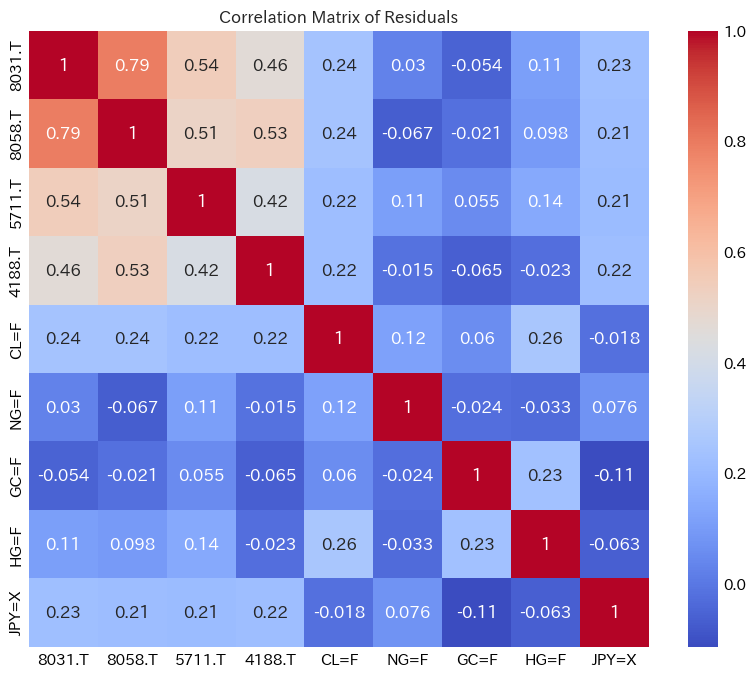

In [38]:
_temp_label = df_base_2023_logged_selected.columns

# 残差の相関行列の取得
correlation_matrix = _result.resid_corr

# ヒートマップの作成
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            xticklabels=_temp_label, 
            yticklabels=_temp_label)
plt.title('Correlation Matrix of Residuals')
plt.show()

## グレンジャー因果

GC - データの設定

In [39]:
_temp_data = df_base_2023_logged_selected

GC - グレンジャー因果の

In [40]:
from copy import deepcopy

def causality_vs_each(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        target_var = vs.pop(i)
        for causing_var in vs:
            test_result = model.test_causality(target_var, causing_var, kind='f')
            print(test_result.summary())

In [41]:
causality_vs_each(_temp_data.copy(), _result)

Granger causality F-test. H_0: 8058.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.7355          3.002   0.479 (2, 1521)
-----------------------------------------------
Granger causality F-test. H_0: 5711.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.668          3.002   0.189 (2, 1521)
-----------------------------------------------
Granger causality F-test. H_0: 4188.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.2292          3.002   0.795 (2, 1521)
-----------------------------------------------
Granger causality F-test. H_0: CL=F does not G

GC - ネットワークグラフの作成

In [42]:
def causality_vs_network(data, model):
    columns = data.columns.tolist()
    causality_results = []

    for i in range(len(columns)):
        vs = deepcopy(columns)
        target_var = vs.pop(i)
        for causing_var in vs:
            test_result = model.test_causality(target_var, causing_var, kind='f')
            # print(test_result.summary())
            causality_results.append({
                'caused': target_var,
                'causing': causing_var,
                'p_value': test_result.pvalue,
                'test_statistic': test_result.test_statistic
            })
    return causality_results

In [43]:
# モデルから結果を取得
results_for_network = causality_vs_network(_temp_data, _result)

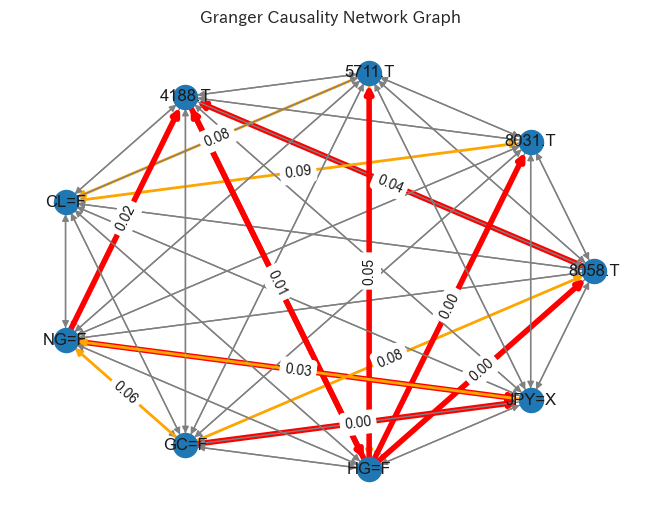

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_causality_graph(causality_results):
    G = nx.DiGraph()
    edge_labels = {}
    
    # 因果関係の追加
    for result in causality_results:
        # エッジの太さと色を設定
        if result['p_value'] <= 0.05:  # 有意水準5%
            weight, color = 4, 'red'
            # 有意水準5%以下の p 値をエッジラベルとして追加
            edge_labels[(result['causing'], result['caused'])] = f"{result['p_value']:.2f}"
        elif result['p_value'] <= 0.1:  # 有意水準10%
            weight, color = 2, 'orange'
            # 有意水準10%以下の p 値をエッジラベルとして追加
            edge_labels[(result['causing'], result['caused'])] = f"{result['p_value']:.2f}"
        else:  # 有意水準10%以上
            weight, color = 1, 'grey'

        # エッジの追加
        G.add_edge(result['causing'], result['caused'], 
                    weight=weight, color=color)

    # エッジの属性に基づいてグラフを描画
    pos = nx.circular_layout(G)  # ノードの位置
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]
    edge_weights = [G[u][v]['weight'] for u, v in edges]

    nx.draw(G, pos, edge_color=edge_colors, width=edge_weights, with_labels=True, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # エッジラベルの描画
    
    plt.title('Granger Causality Network Graph')
    plt.show()

# グラフの描画
draw_causality_graph(results_for_network)

## インパルス応答

グレンジャー応答の結果出力

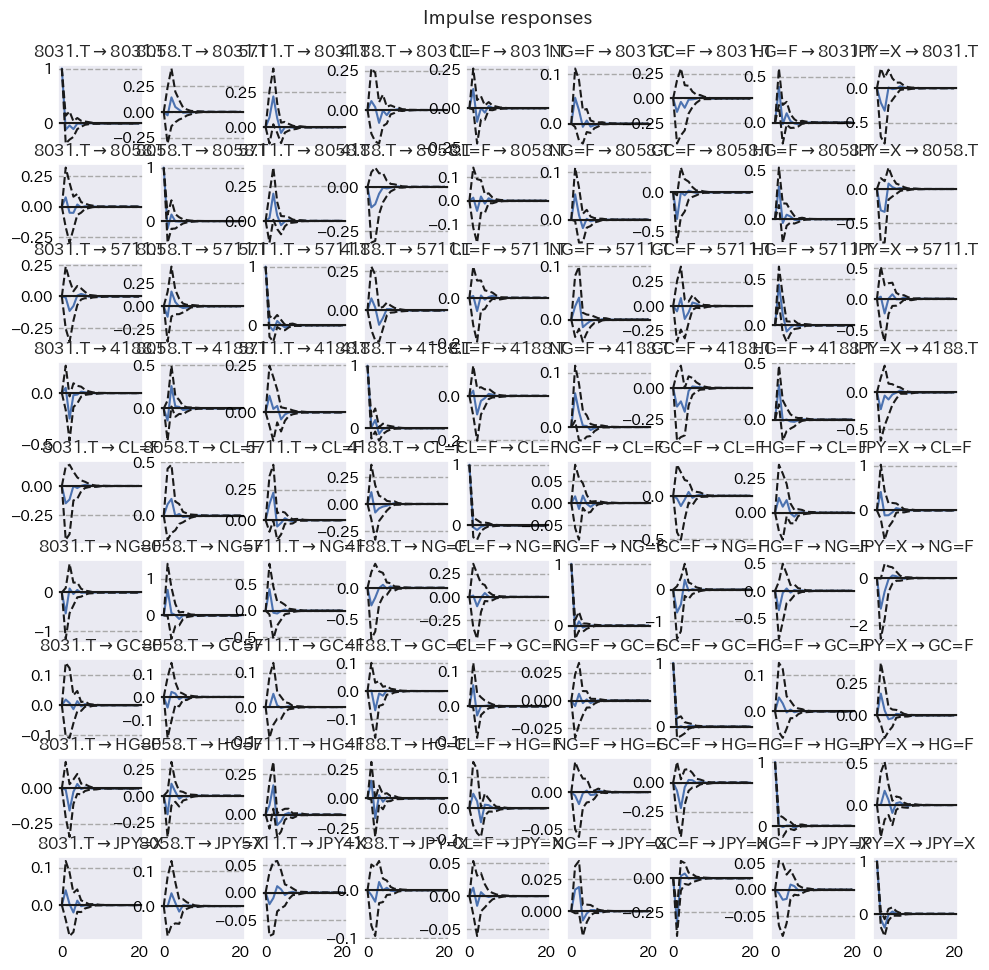

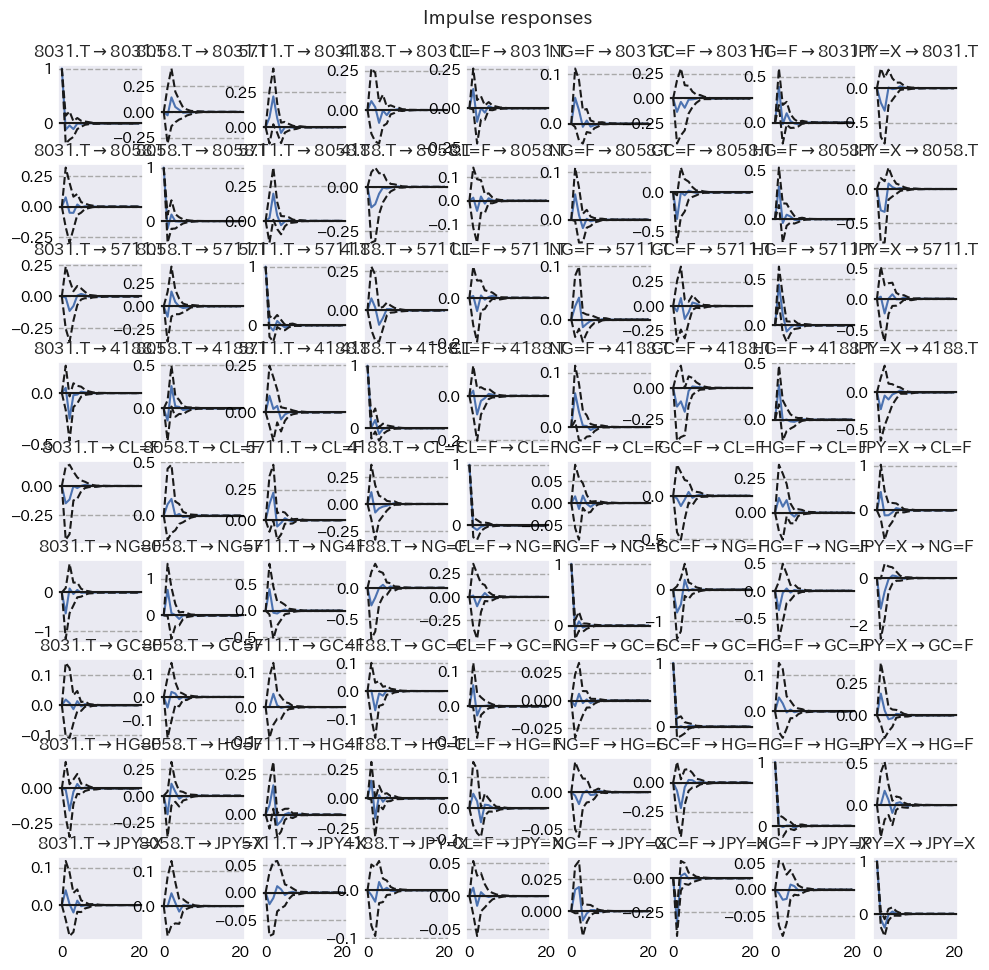

In [46]:
_result.irf(20).plot()

FEVD

In [47]:
FEVD = _result.fevd()
FEVD.summary()

FEVD for 8031.T
       8031.T    8058.T    5711.T    4188.T      CL=F      NG=F      GC=F      HG=F     JPY=X
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.859435  0.000038  0.011215  0.000198  0.047477  0.009468  0.000008  0.068892  0.003269
2    0.822507  0.006349  0.032839  0.000200  0.050883  0.011941  0.000084  0.064662  0.010534
3    0.814381  0.006582  0.033917  0.003310  0.050447  0.012128  0.000760  0.068067  0.010409
4    0.812911  0.006569  0.034731  0.003334  0.050983  0.012277  0.000765  0.068030  0.010401
5    0.812334  0.006622  0.034721  0.003659  0.051056  0.012437  0.000789  0.067990  0.010392
6    0.812130  0.006622  0.034713  0.003668  0.051047  0.012457  0.000807  0.068113  0.010443
7    0.812087  0.006628  0.034712  0.003668  0.051051  0.012471  0.000824  0.068111  0.010449
8    0.812067  0.006628  0.034712  0.003679  0.051050  0.012473  0.000832  0.068109  0.010449
9    0.812064  0.006628  0.034715  0.003679 

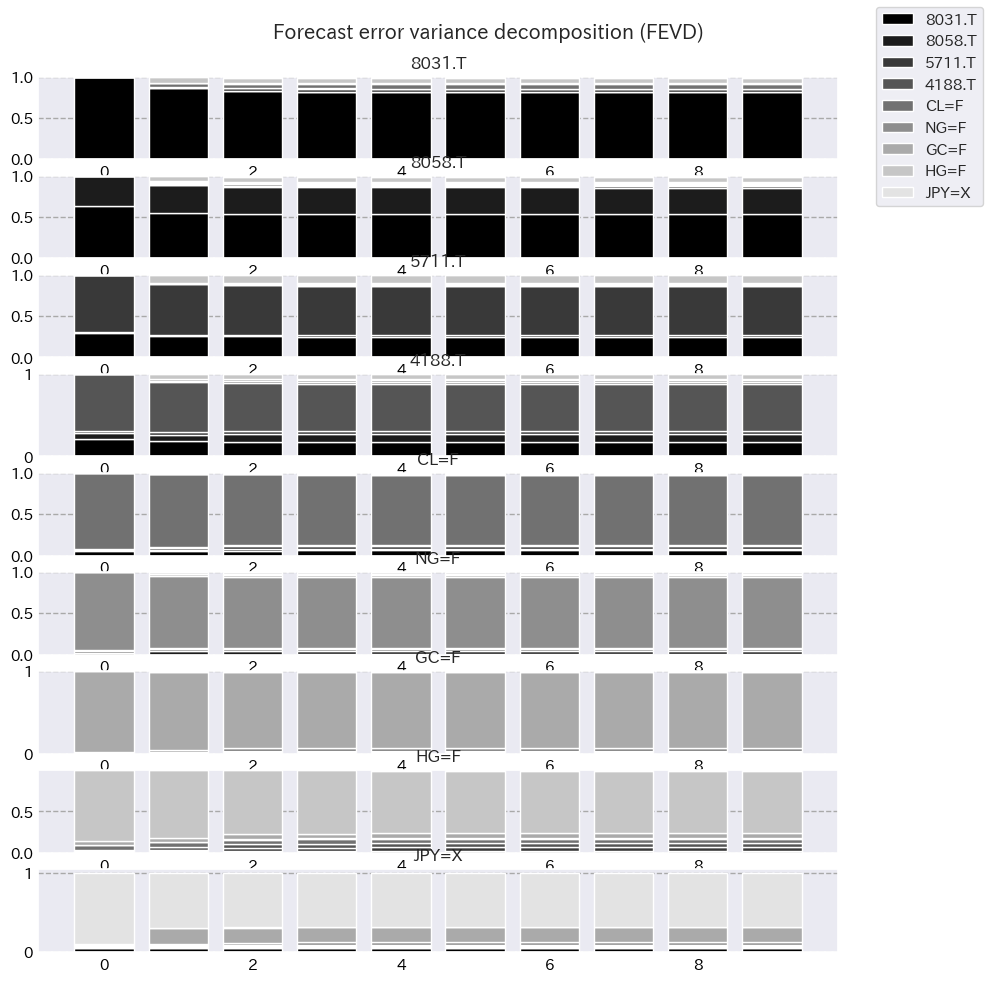

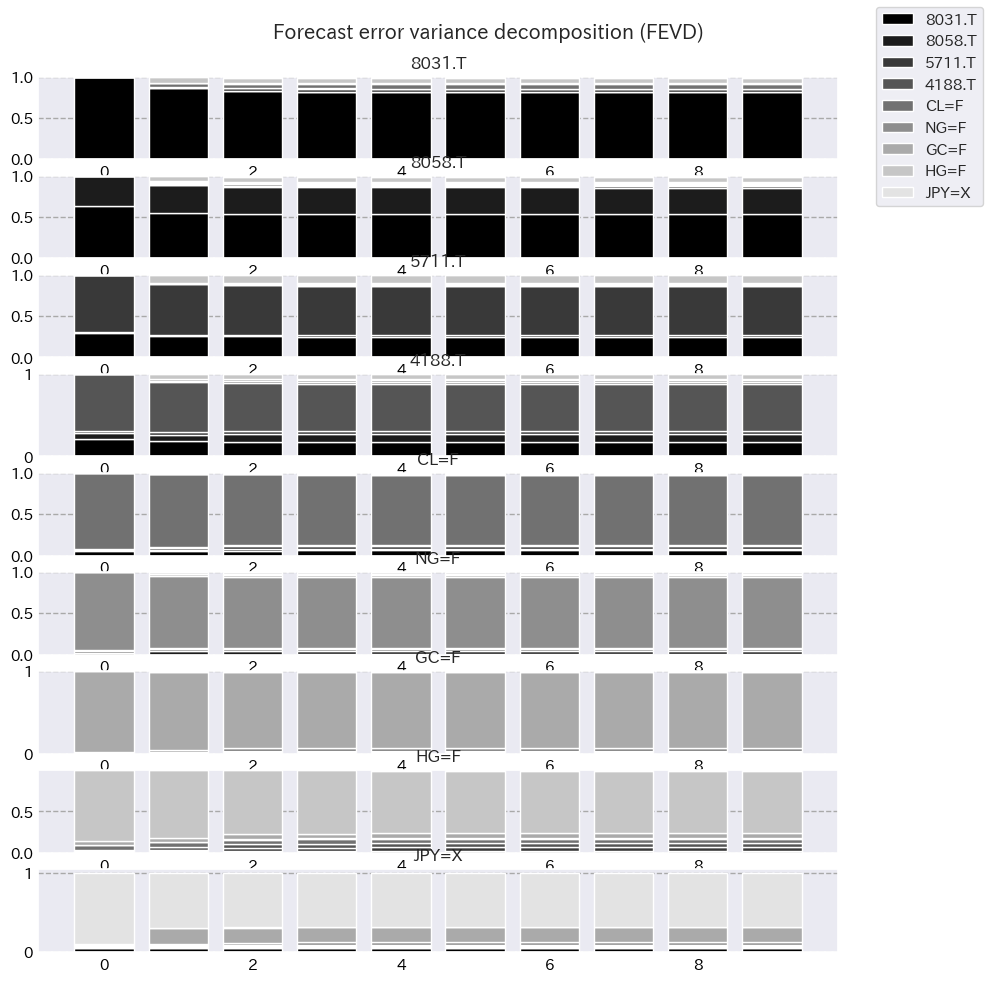

In [48]:
FEVD.plot()

## VECM

Johansen共和分検定

In [49]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

_temp_data_vecm = df_base_2023_logged_selected

johansen_test = coint_johansen(_temp_data_vecm, det_order=-1, k_ar_diff=1)

共和分検定

In [50]:
print(johansen_test.trace_stat)
print(johansen_test.trace_stat_crit_vals)
print(johansen_test.max_eig_stat)
print(johansen_test.max_eig_stat_crit_vals)

[820.37557943 673.17566299 543.02469243 444.68353723 356.9392233
 270.0974692  186.54789379 114.84097291  50.06276901]
[[173.2292 179.5199 191.8122]
 [137.9954 143.6691 154.7977]
 [106.7351 111.7797 121.7375]
 [ 79.5329  83.9383  92.7136]
 [ 56.2839  60.0627  67.6367]
 [ 37.0339  40.1749  46.5716]
 [ 21.7781  24.2761  29.5147]
 [ 10.4741  12.3212  16.364 ]
 [  2.9762   4.1296   6.9406]]
[147.19991643 130.15097057  98.3411552   87.74431393  86.8417541
  83.54957541  71.70692088  64.7782039   50.06276901]
[[51.8528 54.9629 61.3449]
 [45.893  48.8795 55.0335]
 [39.9085 42.7679 48.6606]
 [33.9271 36.6301 42.2333]
 [27.916  30.4428 35.7359]
 [21.837  24.1592 29.0609]
 [15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


In [51]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen共和分検定を実行
johansen_test = coint_johansen(_temp_data_vecm, det_order=-1, k_ar_diff=1)

# 結果を整形して表示
def johansen_summary(johansen_test, alpha=0.05):
    output = pd.DataFrame({
        'Eigen': johansen_test.eig,
        'Trace Stat': johansen_test.lr1,
        'Max-Eig Stat': johansen_test.lr2,
        'Critical Trace 5%': johansen_test.cvt[:, 1],
        'Critical Max-Eig 5%': johansen_test.cvm[:, 1]
    }, index=['r <= ' + str(r) for r in range(johansen_test.eig.size)])
    
    # 有意水準に応じた臨界値のインデックスを取得
    crit_index = {0.1: 2, 0.05: 1, 0.01: 0}.get(alpha, 1)
    
    # 有意水準に応じた列を追加
    output['Signif Trace'] = output['Trace Stat'] > output['Critical Trace 5%']
    output['Signif Max-Eig'] = output['Max-Eig Stat'] > output['Critical Max-Eig 5%']
    
    return output

# 結果の要約
summary = johansen_summary(johansen_test)
summary

,Eigen,Trace Stat,Max-Eig Stat,Critical Trace 5%,Critical Max-Eig 5%,Signif Trace,Signif Max-Eig
r <= 0,0.542957,820.375579,147.199916,179.5199,54.9629,True,True
r <= 1,0.499572,673.175663,130.150971,143.6691,48.8795,True,True
r <= 2,0.407314,543.024692,98.341155,111.7797,42.7679,True,True
r <= 3,0.372948,444.683537,87.744314,83.9383,36.6301,True,True
r <= 4,0.369930,356.939223,86.841754,60.0627,30.4428,True,True
r <= 5,0.358799,270.097469,83.549575,40.1749,24.1592,True,True
r <= 6,0.317109,186.547894,71.706921,24.2761,17.7961,True,True
r <= 7,0.291471,114.840973,64.778204,12.3212,11.2246,True,True
r <= 8,0.233784,50.062769,50.062769,4.1296,4.1296,True,True


VECM

In [52]:
from statsmodels.tsa.vector_ar.vecm import VECM

# VECMモデルをフィット
vecm_model = VECM(_temp_data_vecm, k_ar_diff=2, coint_rank=1)
vecm_result = vecm_model.fit()

# VECMモデルの結果を表示
vecm_result.summary()

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
L1.8031.T.8031,-0.6453,0.132,-4.877,0.000,-0.905,-0.386
L1.8058.T.8031,-0.1959,0.154,-1.276,0.202,-0.497,0.105
L1.5711.T.8031,0.1108,0.128,0.866,0.386,-0.140,0.362
L1.4188.T.8031,0.1149,0.106,1.084,0.278,-0.093,0.323
L1.CL=F.8031,0.0861,0.060,1.435,0.151,-0.032,0.204
L1.NG=F.8031,0.0517,0.029,1.780,0.075,-0.005,0.109
L1.GC=F.8031,-0.2361,0.168,-1.407,0.159,-0.565,0.093
L1.HG=F.8031,0.3009,0.102,2.943,0.003,0.101,0.501
L1.JPY=X.8031,-0.2070,0.211,-0.982,0.326,-0.620,0.206
L2.8031.T.8031,-0.2279,0.113,-2.015,0.044,-0.450,-0.006


最適化VECM

In [53]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank

# ラグオーダーの選択
model = VAR(_temp_data_vecm)
order = model.select_order(maxlags=10)
print(order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -76.99     -76.83*   3.678e-34     -76.92*
1      -77.02*      -75.43  3.544e-34*      -76.38
2       -76.73      -73.70   4.763e-34      -75.50
3       -76.30      -71.83   7.452e-34      -74.49
4       -76.04      -70.13   9.986e-34      -73.65
5       -75.75      -68.41   1.401e-33      -72.77
6       -75.48      -66.70   1.978e-33      -71.92
7       -75.51      -65.29   2.151e-33      -71.37
8       -75.19      -63.53   3.464e-33      -70.46
9       -75.19      -62.10   4.256e-33      -69.88
10      -75.39      -60.86   4.550e-33      -69.50
--------------------------------------------------


/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [54]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank

# ラグオーダーの選択
model = VAR(_temp_data_vecm)
order = model.select_order(maxlags=10)
print(order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -76.99     -76.83*   3.678e-34     -76.92*
1      -77.02*      -75.43  3.544e-34*      -76.38
2       -76.73      -73.70   4.763e-34      -75.50
3       -76.30      -71.83   7.452e-34      -74.49
4       -76.04      -70.13   9.986e-34      -73.65
5       -75.75      -68.41   1.401e-33      -72.77
6       -75.48      -66.70   1.978e-33      -71.92
7       -75.51      -65.29   2.151e-33      -71.37
8       -75.19      -63.53   3.464e-33      -70.46
9       -75.19      -62.10   4.256e-33      -69.88
10      -75.39      -60.86   4.550e-33      -69.50
--------------------------------------------------


/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
# Johansen共和分検定による共和分ランクの選択
rank_test = select_coint_rank(_temp_data_vecm, det_order=-1, k_ar_diff=order.selected_orders['aic'], method='trace', signif=0.05)
print(rank_test.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   9          820.4          179.5
  1   9          673.2          143.7
  2   9          543.0          111.8
  3   9          444.7          83.94
  4   9          356.9          60.06
  5   9          270.1          40.17
  6   9          186.5          24.28
  7   9          114.8          12.32
  8   9          50.06          4.130
-------------------------------------


In [56]:
# VECMモデルの推定
vecm = VECM(_temp_data_vecm, coint_rank=rank_test.rank, k_ar_diff=order.selected_orders['aic'])
vecm_fit = vecm.fit()
print(vecm_fit.summary())

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation 8031.T
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.8031.T.8031    -0.0108      0.118     -0.092      0.927      -0.242       0.220
L1.8058.T.8031    -0.1666      0.129     -1.296      0.195      -0.419       0.085
L1.5711.T.8031    -0.1524      0.090     -1.693      0.090      -0.329       0.024
L1.4188.T.8031     0.0274      0.101      0.271      0.787      -0.171       0.226
L1.CL=F.8031       0.0818      0.066      1.233      0.218      -0.048       0.212
L1.NG=F.8031      -0.0307      0.028     -1.088      0.277      -0.086       0.025
L1.GC=F.8031      -0.0001      0.173     -0.001      0.999      -0.340       0.339
L1.HG=F.8031       0.0222      0.102      0.219      0.827      -0.177       0.222
L1.JPY=X.8031      0.2826      0.212      1.334      0.182      -0.133       0.698
D

グレンジャー因果

In [57]:
# データセット内の全ての変数ペアについてGranger因果関係テスト
for caused in _temp_data_vecm.columns:
    for causing in _temp_data_vecm.columns:
        if caused != causing:
            granger_test = vecm_fit.test_granger_causality(caused=caused, causing=causing)
            print(f'Granger causality test for {causing} causing {caused}:')
            print(granger_test.summary())
            print()

Granger causality test for 8058.T causing 8031.T:
Granger causality F-test. H_0: 8058.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.014          3.002   0.363 (2, 1440)
-----------------------------------------------

Granger causality test for 5711.T causing 8031.T:
Granger causality F-test. H_0: 5711.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.618          3.002   0.199 (2, 1440)
-----------------------------------------------

Granger causality test for 4188.T causing 8031.T:
Granger causality F-test. H_0: 4188.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
--------------------------------------

Granger causality test for 5711.T causing 8058.T:
Granger causality F-test. H_0: 5711.T does not Granger-cause 8058.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.429          3.002   0.240 (2, 1440)
-----------------------------------------------

Granger causality test for 4188.T causing 8058.T:
Granger causality F-test. H_0: 4188.T does not Granger-cause 8058.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.039          3.002   0.354 (2, 1440)
-----------------------------------------------

Granger causality test for CL=F causing 8058.T:
Granger causality F-test. H_0: CL=F does not Granger-cause 8058.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
------------------------------------------

## GARCH

In [121]:
selected_list = df_base_2023_selected.columns

_temp_garch_all = df_base_da[selected_list].copy()
display(_temp_garch_all)
_temp_garch_2023 = df_base_2023_selected.copy()
display(_temp_garch_2023)

,8031.T,8058.T,5711.T,4188.T,CL=F,NG=F,GC=F,HG=F,JPY=X
Date,,,,,,,,,
2010-11-01,751.439819,1220.801392,1943.296387,274.705902,82.949997,3.832,1350.199951,3.7785,80.405998
2010-11-02,746.042480,1236.533569,1928.055054,286.068451,83.900002,3.870,1356.400024,3.8335,80.558998
2010-11-04,757.437012,1274.290283,1950.917114,292.083923,86.489998,3.856,1382.699951,3.9065,81.050003
2010-11-05,791.021240,1312.676270,2004.262451,302.109711,86.849998,3.937,1397.300049,3.9440,80.776001
2010-11-08,810.811401,1318.339722,2072.849609,308.125183,87.059998,4.088,1402.800049,3.9525,81.139999
...,...,...,...,...,...,...,...,...,...
2023-11-02,5553.000000,6891.000000,2447.500000,929.599976,82.459999,3.472,1985.599976,3.6670,150.574997
2023-11-06,5754.000000,6998.000000,2471.500000,968.400024,80.820000,3.264,1981.599976,3.7095,149.449005
2023-11-07,5672.000000,6967.000000,2458.000000,964.099976,77.370003,3.140,1966.800049,3.6700,149.988998


,8031.T,8058.T,5711.T,4188.T,CL=F,NG=F,GC=F,HG=F,JPY=X
Date,,,,,,,,,
2023-01-04,3622.394287,4065.928223,1980.198975,646.878235,72.839996,4.172,1852.800049,3.7395,131.248001
2023-01-05,3611.751709,4089.084717,1963.705322,655.368286,73.669998,3.720,1834.800049,3.8180,132.246002
2023-01-06,3591.433838,4052.419922,1979.228760,655.657654,73.769997,3.710,1864.199951,3.9085,133.307007
2023-01-10,3620.459229,4077.506348,2021.918091,662.796997,75.120003,3.639,1871.599976,4.0670,131.729004
2023-01-11,3684.315674,4138.292480,2069.458496,662.604004,77.410004,3.671,1874.599976,4.1545,132.100998
...,...,...,...,...,...,...,...,...,...
2023-11-02,5553.000000,6891.000000,2447.500000,929.599976,82.459999,3.472,1985.599976,3.6670,150.574997
2023-11-06,5754.000000,6998.000000,2471.500000,968.400024,80.820000,3.264,1981.599976,3.7095,149.449005
2023-11-07,5672.000000,6967.000000,2458.000000,964.099976,77.370003,3.140,1966.800049,3.6700,149.988998


In [122]:
import pandas as pd
from arch import arch_model

_temp_garch_2023 = calculate_garch_volatility(_temp_garch_2023)
display(_temp_garch_2023)

_temp_garch_all = calculate_garch_volatility(_temp_garch_all)
display(_temp_garch_all)

,8031.T,8058.T,5711.T,4188.T,CL=F,NG=F,GC=F,HG=F,JPY=X
Date,,,,,,,,,
2023-01-05,1.283693,1.540903,1.636886,1.494055,1.750809,5.692617,0.844955,1.629609,0.820754
2023-01-06,1.297581,1.537715,1.664594,1.478370,1.729227,5.673635,0.849272,1.653564,0.818027
2023-01-10,1.315219,1.557586,1.680020,1.425678,1.687179,5.654747,0.918735,1.712506,0.815308
2023-01-11,1.327744,1.550878,1.688657,1.402142,1.715168,5.635955,0.881658,2.080530,0.812599
2023-01-12,1.368659,1.569997,1.693509,1.355829,1.858995,5.617257,0.843814,1.997806,0.809898
...,...,...,...,...,...,...,...,...,...
2023-11-02,1.861693,1.812197,1.699765,3.388347,2.356938,3.342413,0.738856,1.116570,0.414823
2023-11-06,1.841171,2.036581,1.699765,3.221230,2.350864,3.336602,0.724806,1.106478,0.413445
2023-11-07,1.928769,1.945174,1.699765,3.286386,2.326322,3.330830,0.708498,1.150567,0.412071


/Users/klynoaguilar/Desktop/01_school/Zemi/23_11_24_week-05/../database/Functions.py:306: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = 100 * dataframe[column].pct_change().dropna()
/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/klynoaguilar/Desktop/01_school/Zemi/23_11_24_week-05/../database/Functions.py:306: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = 100 * dataframe[column].pct_change().dropn

,8031.T,8058.T,5711.T,4188.T,CL=F,NG=F,GC=F,HG=F,JPY=X
Date,,,,,,,,,
2010-11-02,1.562422,1.418580,1.923862,2.091048,1.664207,2.731436,1.068275,1.755572,0.487617
2010-11-04,1.519260,1.410673,1.865212,2.325423,1.641612,2.645446,1.052825,1.736582,0.475780
2010-11-05,1.516623,1.645444,1.828992,2.284321,1.809617,2.553792,1.093731,1.736920,0.485751
2010-11-08,1.910448,1.812534,1.939754,2.383766,1.753219,2.529882,1.091430,1.704296,0.480949
2010-11-09,1.949957,1.710773,2.119883,2.327666,1.697513,2.663787,1.074411,1.662324,0.479848
...,...,...,...,...,...,...,...,...,...
2023-11-02,1.782735,1.867509,1.831738,3.380715,2.550632,3.866964,0.861975,1.129416,0.505897
2023-11-06,1.744588,2.228755,1.767407,3.177725,2.553451,3.719951,0.851465,1.118426,0.507271
2023-11-07,1.948466,2.130700,1.732841,3.225527,2.527264,3.965929,0.839950,1.126292,0.529861


In [136]:
from arch import arch_model

# 対象のの株価データの取得
mitsubishi_data = _temp_garch_all['4188.T']

# ログ収益率の計算
returns = 100 * mitsubishi_data.pct_change().dropna()

# GARCH(1, 1)モデルの適用
model = arch_model(returns, vol='Garch', p=1, q=1)
model_result = model.fit()

# 結果の表示
print(model_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17417.016060396432
Iteration:      2,   Func. Count:     13,   Neg. LLF: 234145.99270937635
Iteration:      3,   Func. Count:     21,   Neg. LLF: 10999.091580553017
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11057.037441611019
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10994.762317026743
Iteration:      6,   Func. Count:     39,   Neg. LLF: 11114.428300534255
Iteration:      7,   Func. Count:     45,   Neg. LLF: 10993.583249637904
Iteration:      8,   Func. Count:     50,   Neg. LLF: 11057.395551451407
Iteration:      9,   Func. Count:     56,   Neg. LLF: 11045.483563496606
Iteration:     10,   Func. Count:     62,   Neg. LLF: 11041.039815700633
Iteration:     11,   Func. Count:     68,   Neg. LLF: 11040.446673498227
Iteration:     12,   Func. Count:     74,   Neg. LLF: 11039.271329886957
Iteration:     13,   Func. Count:     80,   Neg. LLF: 11079.068257521143
Iteration:     14,   Func. Count:     86,   Neg. LL

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

GARCHを用いた予測

In [82]:
forecasts = model_result.forecast(horizon=10)
forecasts.variance[-1:]

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2023-11-09,50.410058,51.275854,51.296767,51.297272,51.297284,51.297284,51.297284,51.297284,51.297284,51.297284


比較ボラティリティのプロット

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

def plot_actual_vs_garch_volatility(time_series):
    """
    実際のボラティリティとGARCHモデルに基づくボラティリティをプロットする関数。

    :param time_series: 時系列データのPandas Series
    """
    # 実際のボラティリティの計算（窓幅30日の移動標準偏差）
    actual_volatility = time_series.rolling(window=30).std()

    # GARCHモデルの適用
    model = arch_model(time_series, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    garch_volatility = model_fit.conditional_volatility

    # プロット
    plt.figure(figsize=(10, 6))
    actual_volatility.plot(label='Actual Volatility (30-day rolling std)')
    garch_volatility.plot(label='GARCH Volatility')
    plt.title('Actual vs GARCH Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# この関数を使用するには、時系列データを引数として渡す
# 例: plot_actual_vs_garch_volatility(your_time_series_data)


In [111]:
df

,8031.T,8058.T,5711.T,4188.T,CL=F,NG=F,GC=F,HG=F,JPY=X
Date,,,,,,,,,
2023-01-05,1.283693,1.540903,1.636886,1.494055,1.750809,5.692617,0.844955,1.629609,0.820754
2023-01-06,1.297581,1.537715,1.664594,1.478370,1.729227,5.673635,0.849272,1.653564,0.818027
2023-01-10,1.315219,1.557586,1.680020,1.425678,1.687179,5.654747,0.918735,1.712506,0.815308
2023-01-11,1.327744,1.550878,1.688657,1.402142,1.715168,5.635955,0.881658,2.080530,0.812599
2023-01-12,1.368659,1.569997,1.693509,1.355829,1.858995,5.617257,0.843814,1.997806,0.809898
...,...,...,...,...,...,...,...,...,...
2023-11-02,1.861693,1.812197,1.699765,3.388347,2.356938,3.342413,0.738856,1.116570,0.414823
2023-11-06,1.841171,2.036581,1.699765,3.221230,2.350864,3.336602,0.724806,1.106478,0.413445
2023-11-07,1.928769,1.945174,1.699765,3.286386,2.326322,3.330830,0.708498,1.150567,0.412071


/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


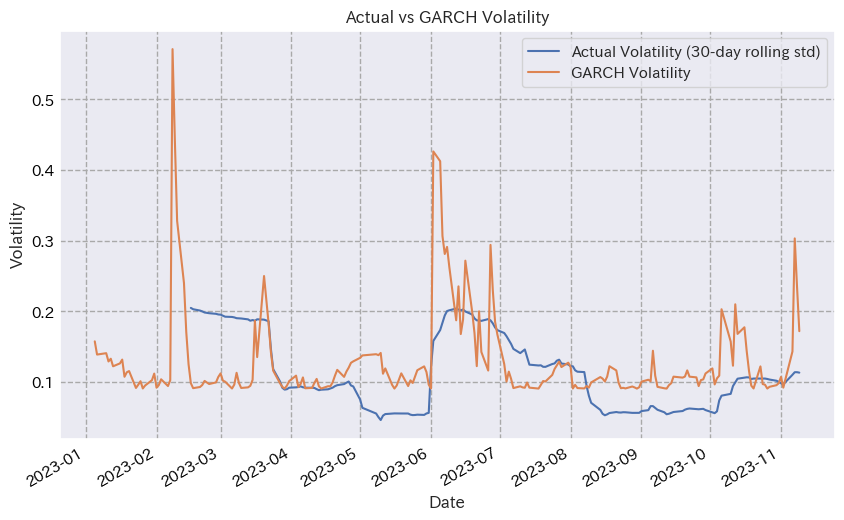

In [115]:
df = _temp_garch_2023

# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# 任意の時系列データ列を選択
time_series_data = df['8058.T']

# 実際のボラティリティとGARCHボラティリティをプロット
plot_actual_vs_garch_volatility(time_series_data)


ボラティリティの可視化

In [101]:
df_base_stock_da

,TYO,F,GM,HMC,STLA,TOYOF
Date,,,,,,
2013-10-01,24.750,17.19,35.91,38.22,8.06,63.8800
2013-10-02,24.629,17.21,35.94,38.28,8.06,63.2400
2013-10-03,24.580,16.95,35.29,38.07,8.06,63.3501
2013-10-04,24.820,17.09,35.70,38.37,8.35,63.9200
2013-10-07,24.630,16.81,35.18,37.91,8.60,63.9200
...,...,...,...,...,...,...
2023-09-25,15.210,12.58,33.06,35.21,19.24,18.4750
2023-09-26,15.280,12.43,32.26,34.73,18.84,18.0450
2023-09-27,15.510,12.39,32.35,34.99,18.81,18.1900


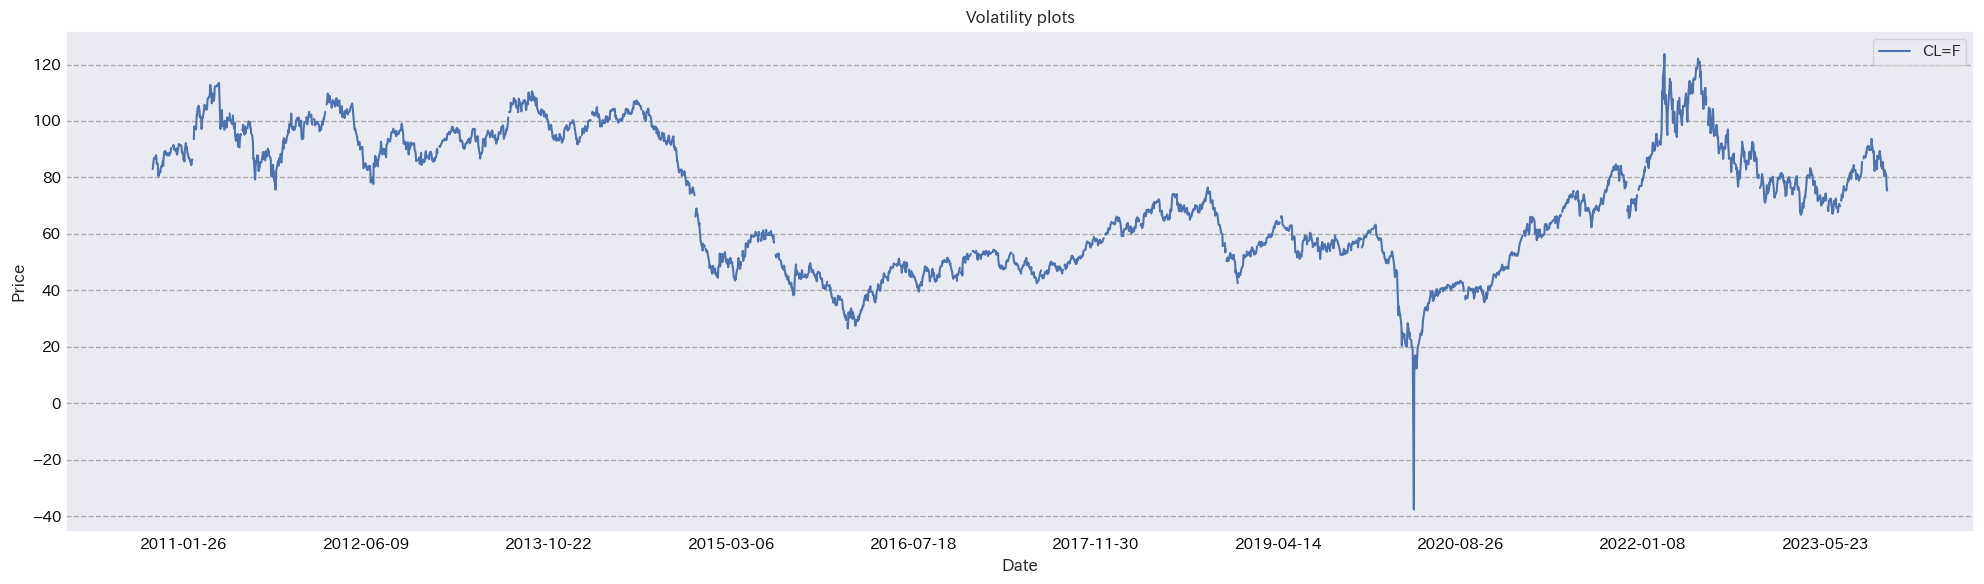

In [104]:
_temp =[
        # '8031.T', 
        # '8058.T', 
        # '5711.T', 
        # '4188.T', 
        'CL=F', 
        # 'NG=F', 
        # 'GC=F', 
        # 'HG=F',
        # 'JPY=X'
        ]
plot_stock_prices('Volatility plots', df_base_da, _temp, xlabel='Date', ylabel='Price', figsize=(20, 6))

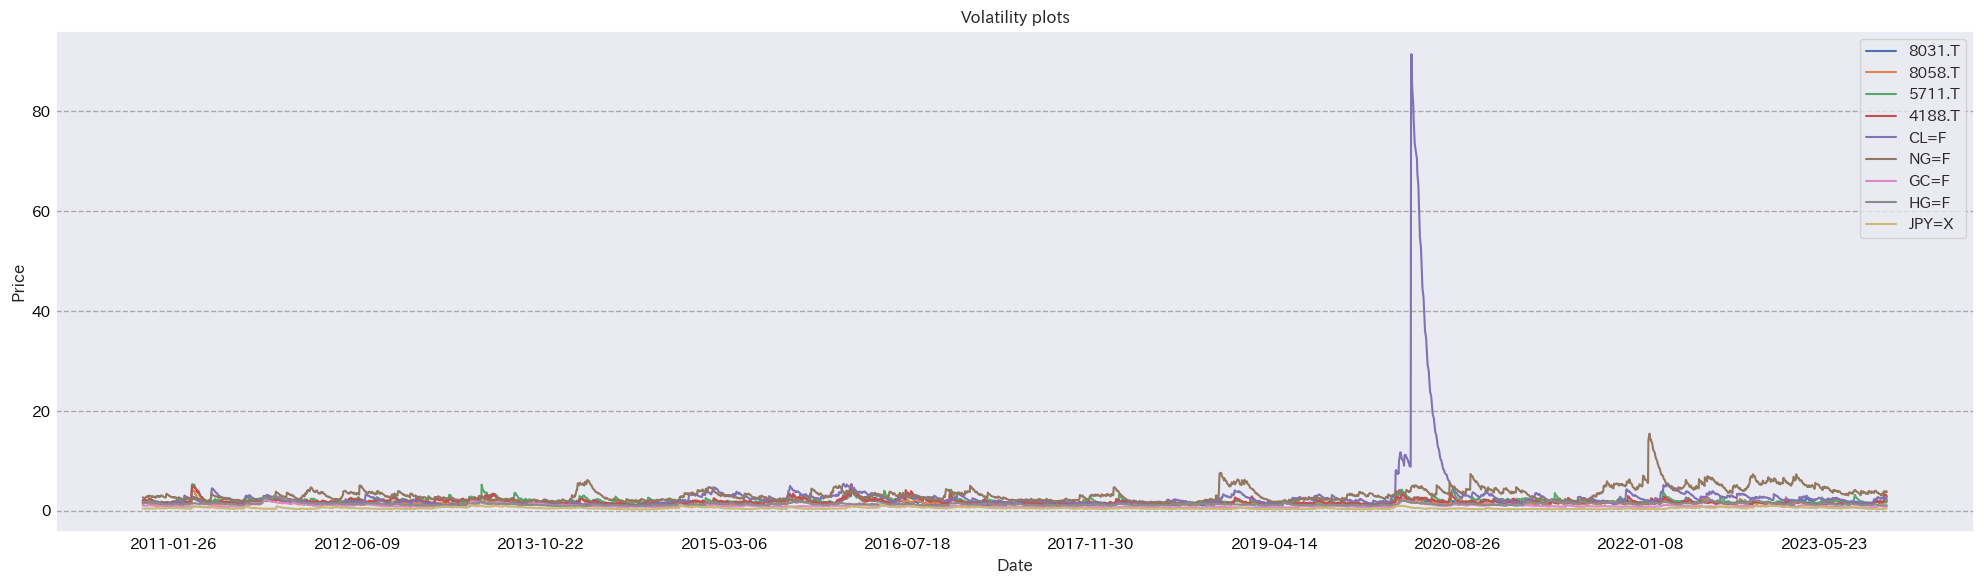

In [99]:
_temp =['8031.T', 
        '8058.T', 
        '5711.T', 
        '4188.T', 
        'CL=F', 
        'NG=F', 
        'GC=F', 
        'HG=F',
        'JPY=X'] 
plot_stock_prices('Volatility plots', _temp_garch_all, _temp, xlabel='Date', ylabel='Price', figsize=(20, 6))

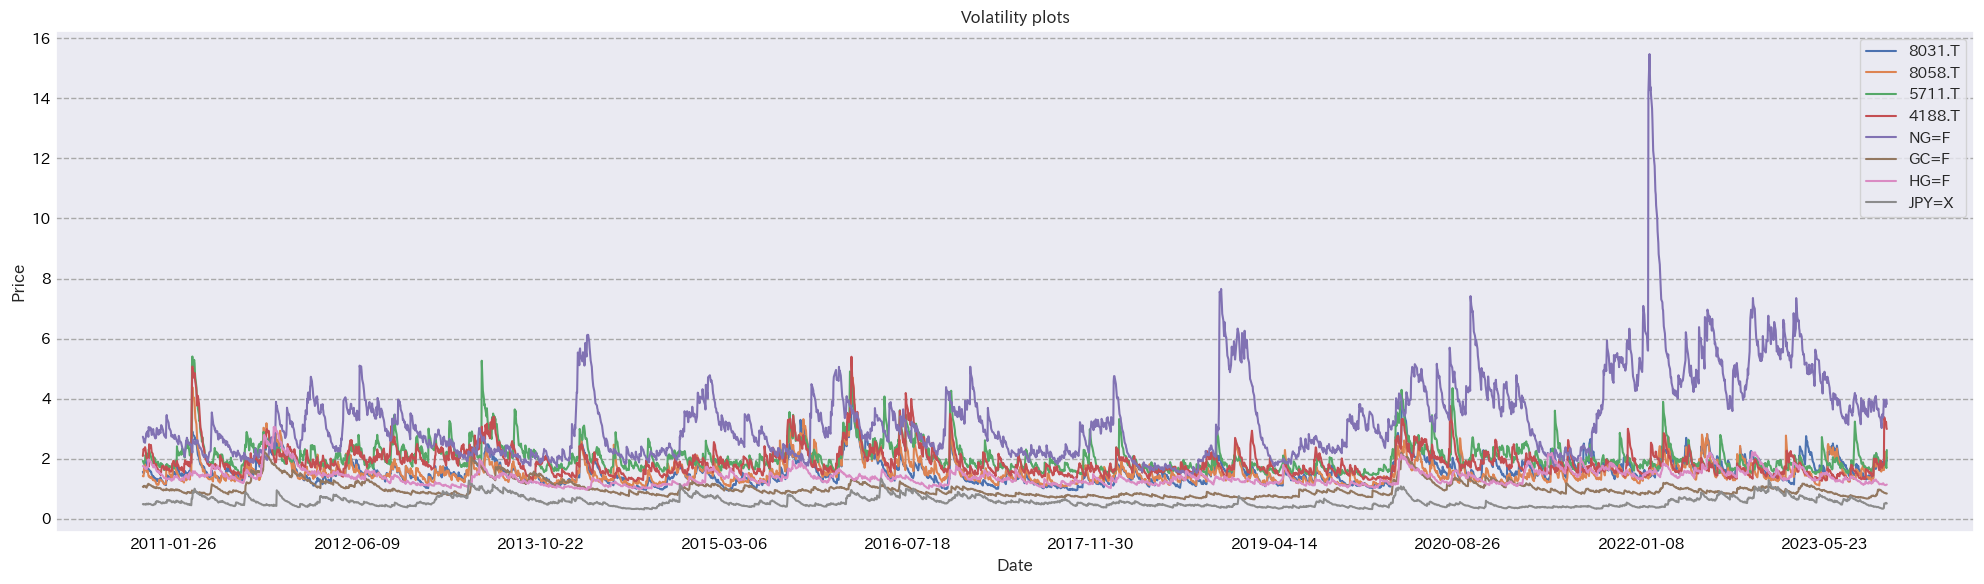

In [126]:
_temp =['8031.T', 
        '8058.T', 
        '5711.T', 
        '4188.T', 
        # 'CL=F', 
        'NG=F', 
        'GC=F', 
        'HG=F',
        'JPY=X'] 
plot_stock_prices('Volatility plots', _temp_garch_all, _temp, xlabel='Date', ylabel='Price', figsize=(20, 6))

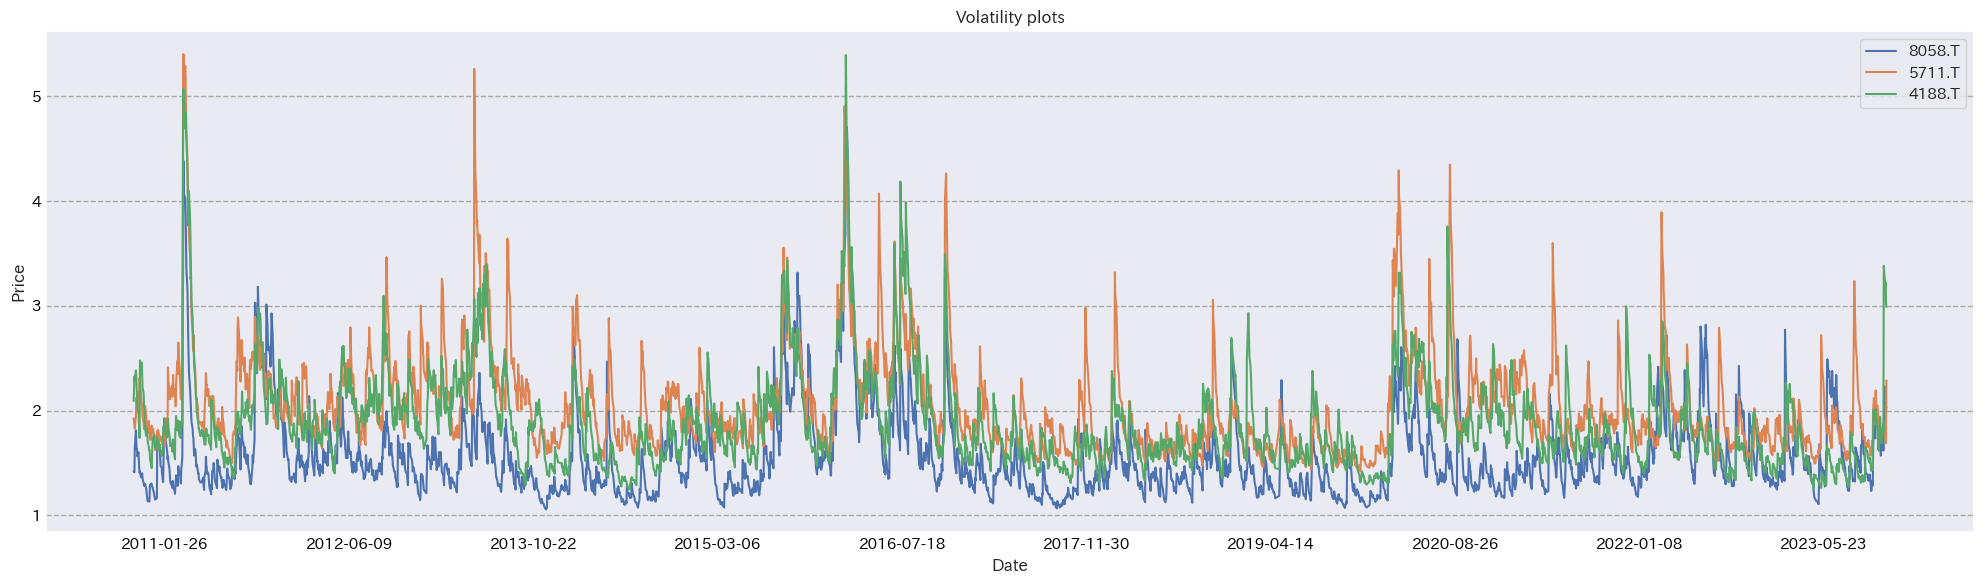

In [87]:
_temp_columns = ['8058.T', '5711.T', '4188.T']
plot_stock_prices('Volatility plots', _temp_garch_all, _temp_columns, xlabel='Date', ylabel='Price', figsize=(20, 6))

GARCHにグレンジャー

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR

model = VAR(_temp_garch_all.copy())

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
display_order_selection(model, 20)

interactive(children=(IntSlider(value=5, description='maxlags', max=20, min=1), Output()), _dom_classes=('widg…

In [ ]:
_temp_lag_select = 4

_result = model.fit(_temp_lag_select)

In [ ]:
_result = model.fit(_temp_lag_select)
_result.summary()

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/statsmodels/tsa/vector_ar/var_model.py:1559: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Nov, 2023
Time:                     14:01:31
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -199.840
Nobs:                     206.000    HQIC:                  -203.044
Log likelihood:           18839.9    FPE:                7.75450e-90
AIC:                     -205.220    Det(Omega_mle):     1.75349e-90
--------------------------------------------------------------------
Results for equation 8031.T
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const          14339106.559851     68723.951161          208.648           0.000
L1.8031.T             0.786958         0.090278            8.717           0.000
L1.8058.T            -0.000873         0.070287           -

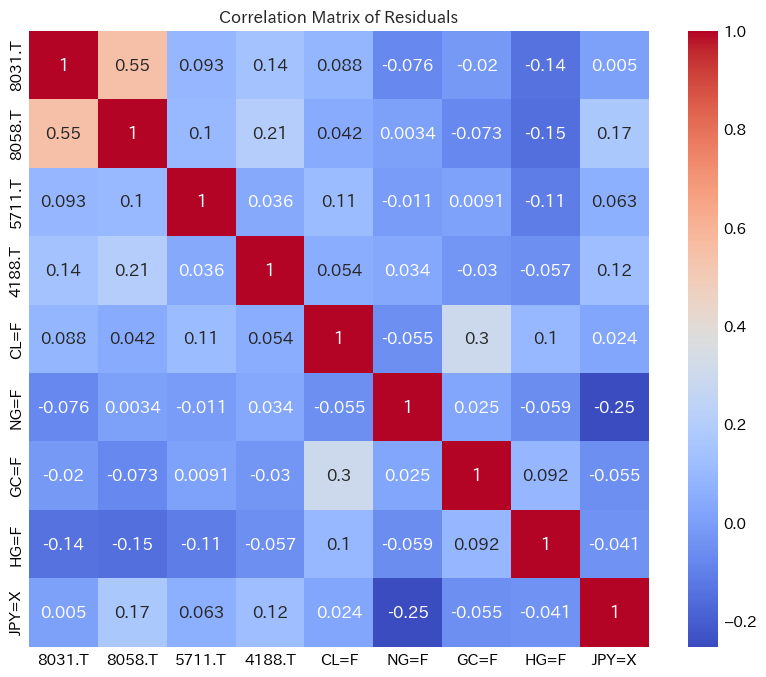

In [ ]:
_temp_label = df_base_2023_logged_selected.columns

# 残差の相関行列の取得
correlation_matrix = _result.resid_corr

# ヒートマップの作成
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            xticklabels=_temp_label, 
            yticklabels=_temp_label)
plt.title('Correlation Matrix of Residuals')
plt.show()

In [ ]:
_temp_data = volatility_df

In [ ]:
causality_vs_each(_temp_data.copy(), _result)

Granger causality F-test. H_0: 8058.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.1504          2.378   0.963 (4, 1521)
-----------------------------------------------
Granger causality F-test. H_0: 5711.T does not Granger-cause 8031.T. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
     4.412e+04          2.378   0.000 (4, 1521)
-----------------------------------------------
Granger causality F-test. H_0: 4188.T does not Granger-cause 8031.T. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.4620          2.378   0.764 (4, 1521)
-----------------------------------------------
Granger causality F-test. H_0: CL=F does not Granger-c

In [ ]:
# モデルから結果を取得
results_for_network = causality_vs_network(_temp_data, _result)

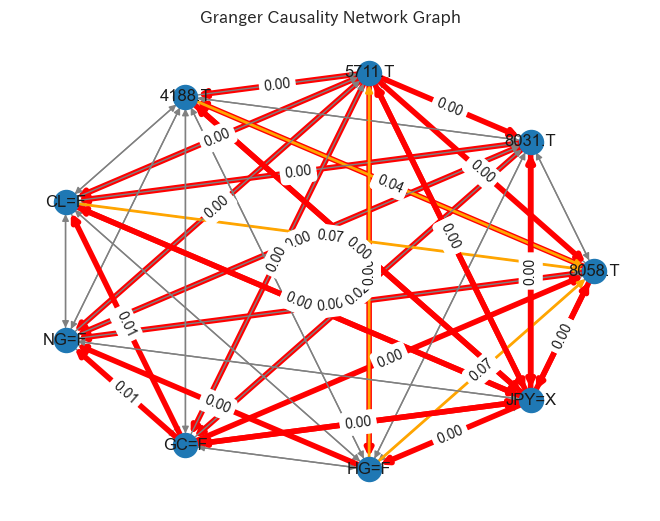

In [ ]:
# グラフの描画
draw_causality_graph(results_for_network)

多変量GARCH

In [116]:
import pandas as pd
from arch import arch_model
from arch.univariate import GARCH, ConstantMean
from arch.__future__ import reindexing
from arch.univariate import ZeroMean
from arch.__future__ import reindexing
from arch.univariate import ConstantMean, GARCH, Normal

# データの読み込み
# 例: CSVファイルから複数の時系列データを読み込む
data = _temp_garch_2023.copy()

# DCCモデルの定義とフィッティング
from arch.univariate import ConstantMean, GARCH, Normal
from arch import arch_model
import numpy as np

# 各時系列データに対してGARCH(1,1)モデルを適用
garch_models = [arch_model(data[col], mean='Zero', vol='Garch', p=1, q=1, dist='Normal') for col in data.columns]

# GARCHモデルのフィッティング
fitted_models = [model.fit(update_freq=5, disp='off') for model in garch_models]

# 残差と条件付きボラティリティの取得
resids = np.column_stack([model.resid for model in fitted_models])
volatility = np.column_stack([model.conditional_volatility for model in fitted_models])

# 相関係数の計算
from arch.__future__ import reindexing
from arch.univariate import ConstantMean, GARCH, Normal
from arch import arch_model
import numpy as np

dcc = ConstantMean(resids)
dcc.volatility = GARCH(1, 0, 1)
dcc.distribution = Normal()
res = dcc.fit(update_freq=5, disp='off')

# 相関係数行列の取得
conditional_correlation = res.conditional_volatility
conditional_correlation

/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04763. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/klynoaguilar/opt/anaconda3/envs/Analysis/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/klynoagu

ValueError: y must be squeezable to 1 dimension

ぼら予測の可視化

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

def predict_and_plot_garch_volatility(time_series, forecast_horizon=10):
    """
    GARCHモデルを用いて将来のボラティリティを予測し、プロットする関数。

    :param time_series: 時系列データのPandas Series
    :param forecast_horizon: 予測の地平線（予測する期間の長さ）
    """
    # GARCHモデルの適用
    model = arch_model(time_series, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')

    # ボラティリティの予測
    forecast = model_fit.forecast(horizon=forecast_horizon)
    future_dates = [time_series.index[-1] + pd.Timedelta(days=i) for i in range(1, forecast_horizon+1)]
    predicted_volatility = forecast.variance.iloc[-1].values ** 0.5

    # プロット
    plt.figure(figsize=(10, 6))
    plt.plot(future_dates, predicted_volatility, label='Predicted Volatility')
    plt.title('Predicted GARCH Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# この関数を使用するには、時系列データを引数として渡す
# 例: predict_and_plot_garch_volatility(your_time_series_data, forecast_horizon=10)


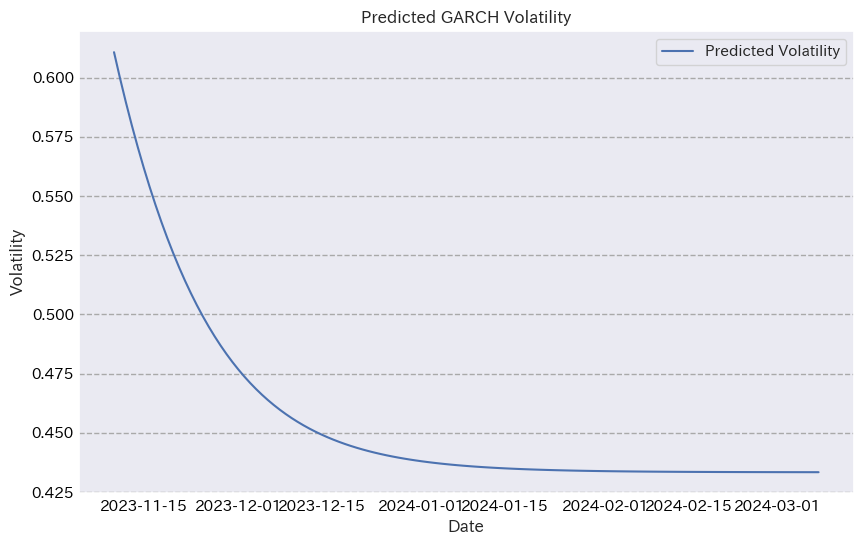

In [132]:
# CSVファイルから時系列データを読み込む
df = _temp_garch_all.copy()

# 任意の時系列データ列を選択
time_series_data = df['8058.T']

# GARCHモデルを用いた将来のボラティリティの予測とプロット
predict_and_plot_garch_volatility(time_series_data, forecast_horizon=120)


# その他